### Business Goal

* *Our goal is to use and optimize Machine Learning models that effectively predict the number of ride-sharing bikes that will be used in any given 1 hour time-period, using available information about that time/day.*

### Import the base packages/libraries

In [345]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import datetime
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_style('whitegrid')
sns.despine()

<Figure size 432x288 with 0 Axes>

### Get and load the data

In [346]:
bike_train=pd.read_csv('../data/train.csv', parse_dates=True)
bike_test=pd.read_csv('../data/test.csv', parse_dates=True)

In [347]:
bike_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [348]:
bike_test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


### Exploratory data analysis

#### Data Fields


* datetime - hourly date + timestamp
* season - 1 = spring, 2 = summer, 3 = fall, 4 = winter
* holiday - whether the day is considered a holiday
* workingday - whether the day is neither a weekend nor holiday
* weather - 
++ 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
++ 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
++ 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
++ 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
* temp - temperature in Celsius
* atemp - "feels like" temperature in Celsius
* humidity - relative humidity
* windspeed - wind speed
* casual - number of non-registered user rentals initiated
* registered - number of registered user rentals initiated
* count - number of total rentals

#### Extract and create year, month, day, weekday, and hour features  from the datetime column

In [349]:
bike_train['datetime']=pd.to_datetime(bike_train.datetime)
bike_test['datetime']=pd.to_datetime(bike_test.datetime)

In [350]:
bike_train['year']= bike_train['datetime'].dt.year
bike_train['month']= bike_train['datetime'].dt.month
bike_train['day']= bike_train['datetime'].dt.day
bike_train['weekday']= bike_train['datetime'].dt.weekday
bike_train['hour']= bike_train['datetime'].dt.hour

bike_test['year']= bike_test['datetime'].dt.year
bike_test['month']= bike_test['datetime'].dt.month
bike_test['day']= bike_test['datetime'].dt.day
bike_test['weekday']= bike_test['datetime'].dt.weekday
bike_test['hour']= bike_test['datetime'].dt.hour

In [351]:
bike_train.drop(['datetime'], axis=1, inplace=True)
bike_test.drop(['datetime'], axis=1, inplace=True)

In [352]:
bike_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,weekday,hour
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,5,0
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,5,1
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,5,2
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,5,3
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,5,4


In [353]:
bike_test.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,weekday,hour
0,1,0,1,1,10.66,11.365,56,26.0027,2011,1,20,3,0
1,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,3,1
2,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,3,2
3,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,3,3
4,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,3,4


#### Preprocessing the data

In [354]:
#basic statistical information
bike_train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,weekday,hour
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,2011.501929,6.521495,9.992559,3.013963,11.541613
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,0.500019,3.444373,5.476608,2.004585,6.915838
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,2011.000000,1.000000,1.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,2011.000000,4.000000,5.000000,1.000000,6.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,2012.000000,7.000000,10.000000,3.000000,12.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,2012.000000,10.000000,15.000000,5.000000,18.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,2012.000000,12.000000,19.000000,6.000000,23.000000


In [355]:
#datatype information
bike_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   casual      10886 non-null  int64  
 9   registered  10886 non-null  int64  
 10  count       10886 non-null  int64  
 11  year        10886 non-null  int64  
 12  month       10886 non-null  int64  
 13  day         10886 non-null  int64  
 14  weekday     10886 non-null  int64  
 15  hour        10886 non-null  int64  
dtypes: float64(3), int64(13)
memory usage: 1.3 MB


In [356]:
bike_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      6493 non-null   int64  
 1   holiday     6493 non-null   int64  
 2   workingday  6493 non-null   int64  
 3   weather     6493 non-null   int64  
 4   temp        6493 non-null   float64
 5   atemp       6493 non-null   float64
 6   humidity    6493 non-null   int64  
 7   windspeed   6493 non-null   float64
 8   year        6493 non-null   int64  
 9   month       6493 non-null   int64  
 10  day         6493 non-null   int64  
 11  weekday     6493 non-null   int64  
 12  hour        6493 non-null   int64  
dtypes: float64(3), int64(10)
memory usage: 659.6 KB


+ The dataset does not have any missing values
+ Although the season, holiday, workingday, weather, month, hour and weekday are the categorical features, dtypes are integer. For this reason, we should convert them to the 'category' dtype

In [357]:
#convert the categorical columns to dtype category
cols_cat=['season', 'holiday', 'workingday', 'weather', 'month', 'hour', 'weekday']
for col in cols_cat:
   bike_train[col]=bike_train[col].astype('category')
   bike_test[col]=bike_test[col].astype('category')

bike_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      10886 non-null  category
 1   holiday     10886 non-null  category
 2   workingday  10886 non-null  category
 3   weather     10886 non-null  category
 4   temp        10886 non-null  float64 
 5   atemp       10886 non-null  float64 
 6   humidity    10886 non-null  int64   
 7   windspeed   10886 non-null  float64 
 8   casual      10886 non-null  int64   
 9   registered  10886 non-null  int64   
 10  count       10886 non-null  int64   
 11  year        10886 non-null  int64   
 12  month       10886 non-null  category
 13  day         10886 non-null  int64   
 14  weekday     10886 non-null  category
 15  hour        10886 non-null  category
dtypes: category(7), float64(3), int64(6)
memory usage: 842.1 KB


In [358]:
bike_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      6493 non-null   category
 1   holiday     6493 non-null   category
 2   workingday  6493 non-null   category
 3   weather     6493 non-null   category
 4   temp        6493 non-null   float64 
 5   atemp       6493 non-null   float64 
 6   humidity    6493 non-null   int64   
 7   windspeed   6493 non-null   float64 
 8   year        6493 non-null   int64   
 9   month       6493 non-null   category
 10  day         6493 non-null   int64   
 11  weekday     6493 non-null   category
 12  hour        6493 non-null   category
dtypes: category(7), float64(3), int64(3)
memory usage: 351.0 KB


<AxesSubplot:xlabel='workingday', ylabel='count'>

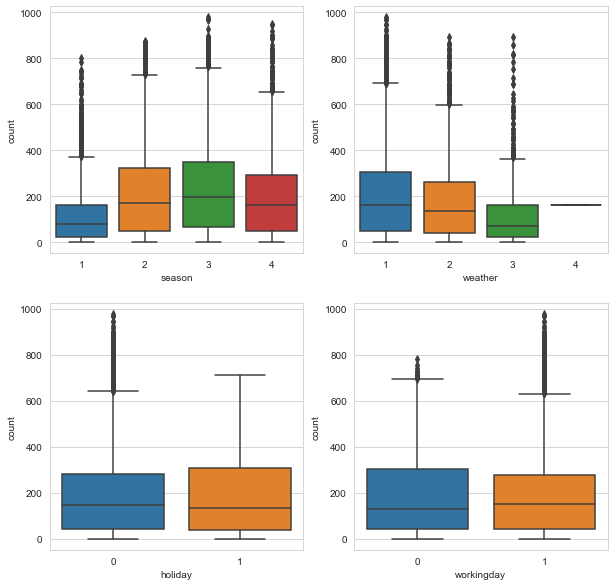

In [359]:
fig,ax = plt.subplots(2,2, figsize=(10,10))

sns.boxplot(data = bike_train, x = 'season', y = 'count', ax = ax[0][0] )
sns.boxplot(data = bike_train, x = 'weather',  y = 'count', ax = ax[0][1])
sns.boxplot(data = bike_train, x = 'holiday', y = 'count', ax = ax[1][0])
sns.boxplot(data = bike_train, x = 'workingday', y = 'count', ax = ax[1][1])

+ Bikes are rented mostly in fall and leastly in spring
+ The demand of bikes is the highest in Clear/Few/Partly Cloudy weather and also in workingdays and not holidays


[Text(0.5, 1.0, '# of bikes rented during the hours'),
 Text(0, 0.5, 'rented bikes')]

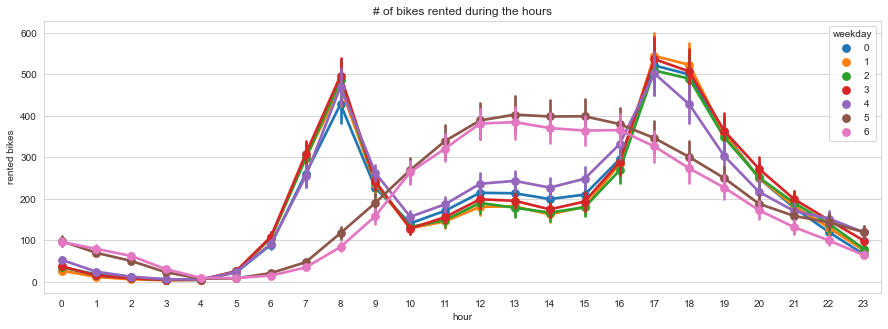

In [360]:
fig, ax=plt.subplots(figsize=(15,5))

sns.pointplot(data=bike_train, x='hour', y='count', hue='weekday')
ax.set(title='# of bikes rented during the hours', ylabel='rented bikes')

+ '5' and '6' are Saturdays and Sundays and on these days the demand of bikes is different according to the other days
+ The demand of bikes is the highest between 7 and 9 in the mornings and 17 and 19 in the evenings
+ From June to September, the hourly demand is on the top

[Text(0.5, 1.0, 'Count of bikes during different months')]

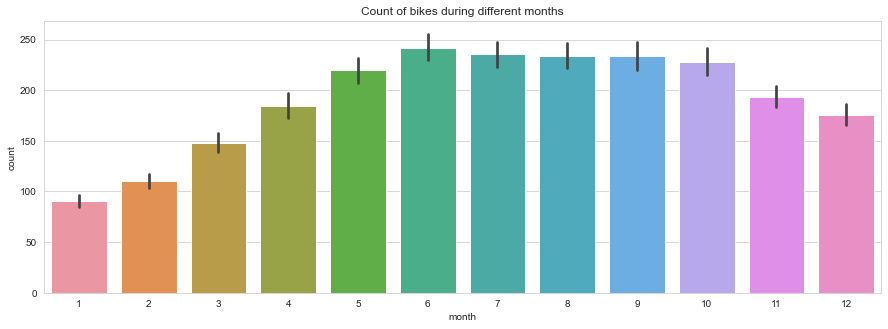

In [361]:

fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(data=bike_train, x='month', y='count')
ax.set(title='Count of bikes during different months')


#### Correlation Matrix

<AxesSubplot:>

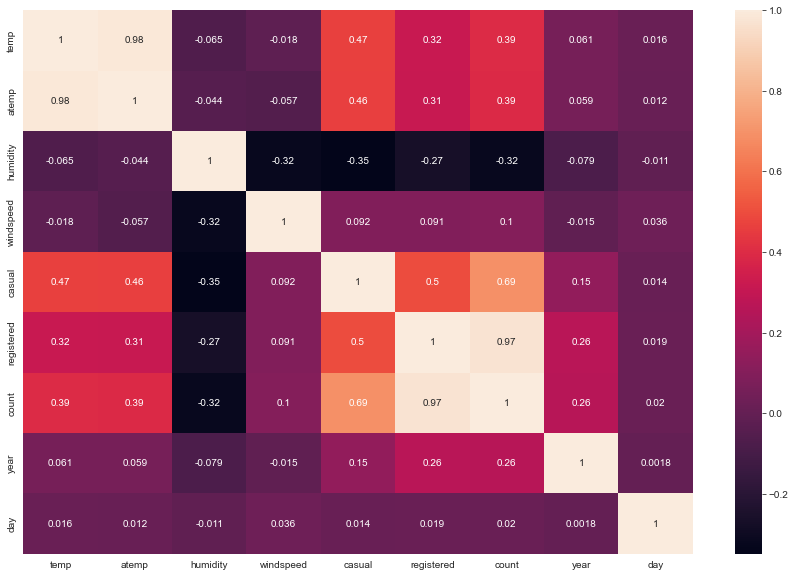

In [362]:
corr=bike_train.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr, annot=True)

+ The correlation between temp and atemp has very high and we should use only one of them. (temp)
+ The correlation between casual-count and registered-count has also very high and sum of casual and registered users is equal to count. Therefore we do not use these columns and drop them.

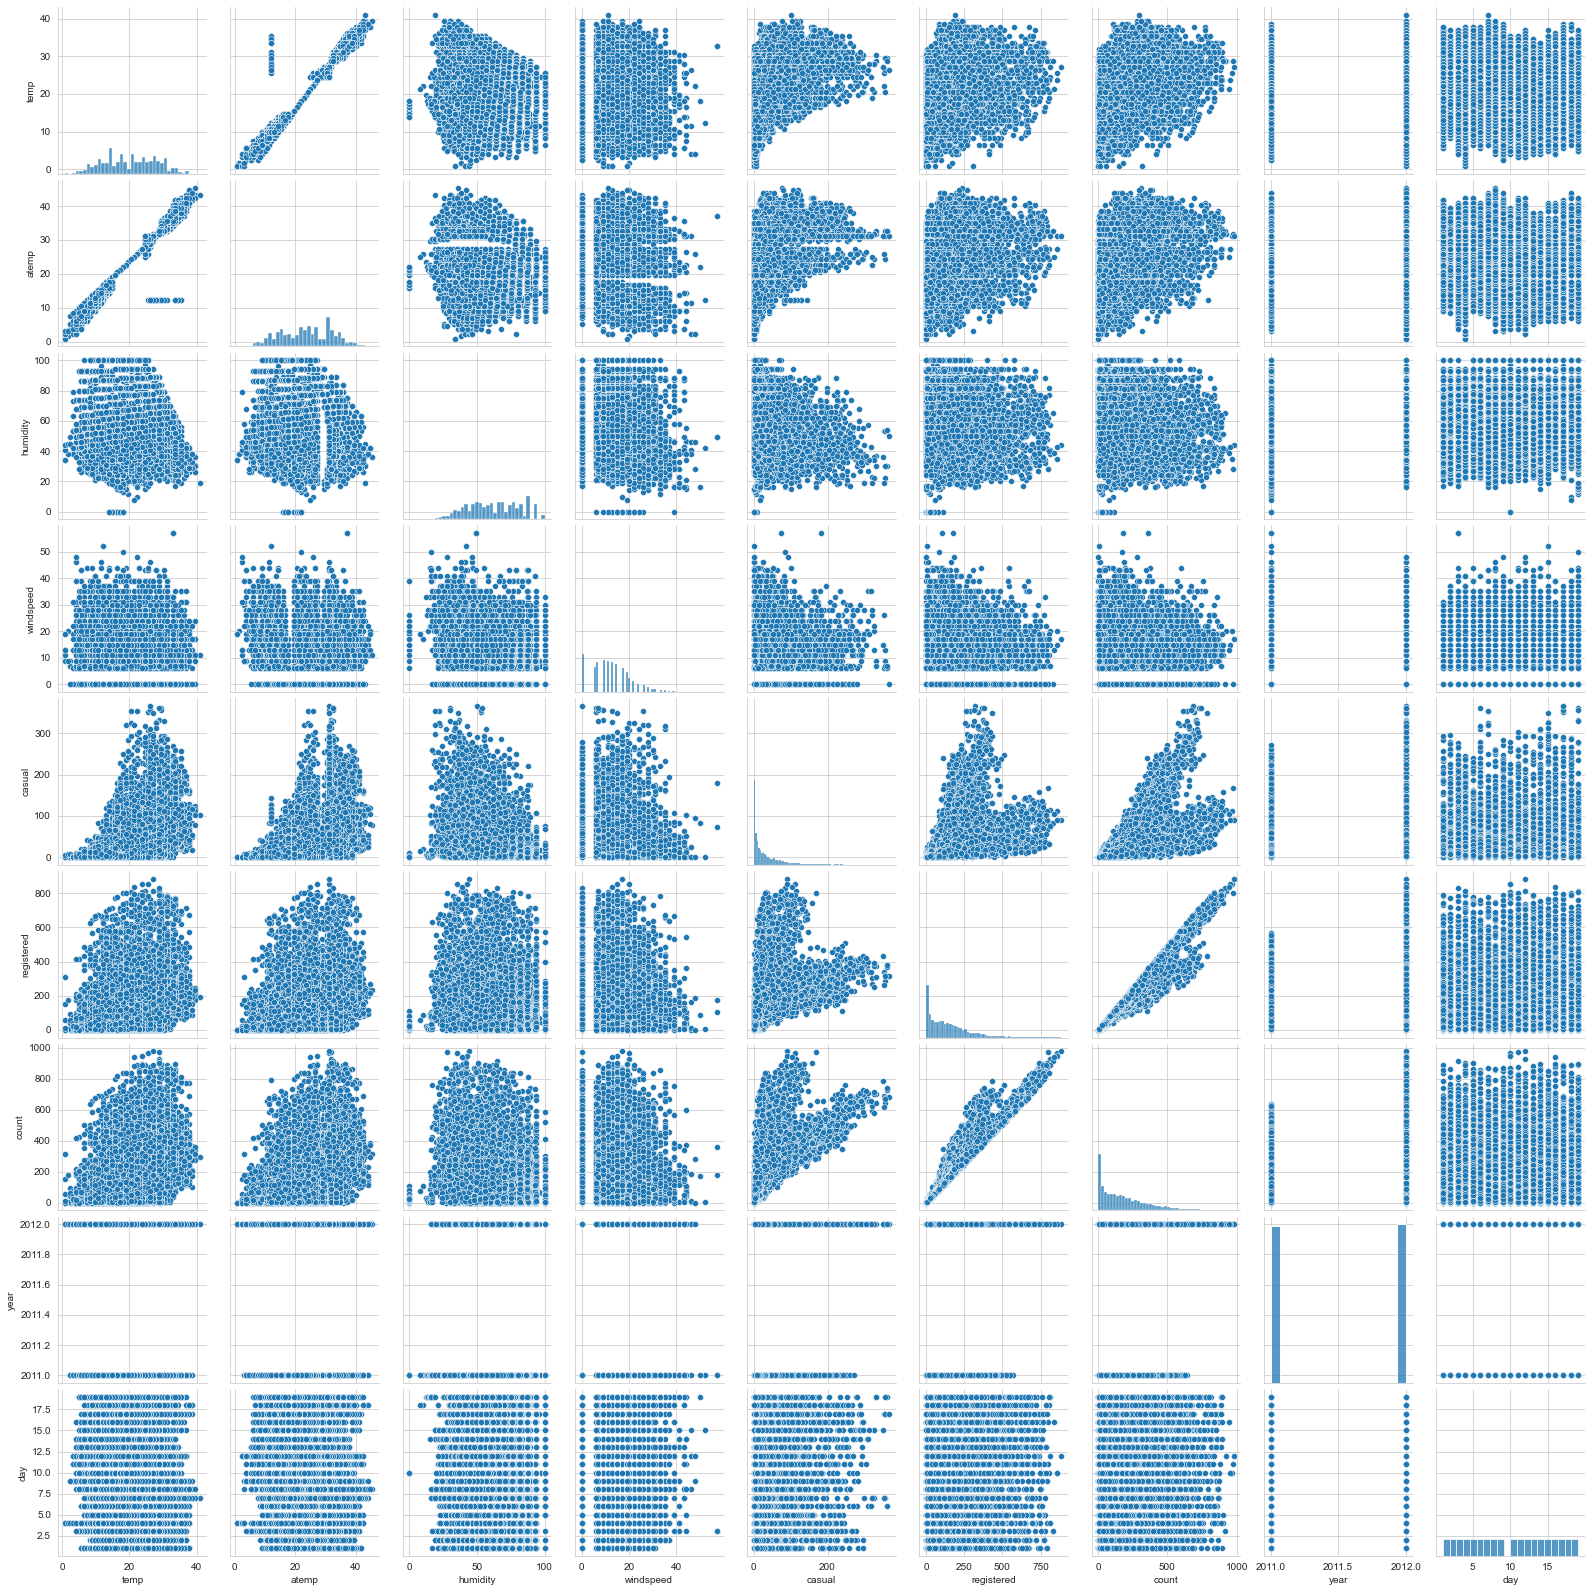

In [363]:
sns.pairplot(data=bike_train)

<Figure size 432x288 with 0 Axes>

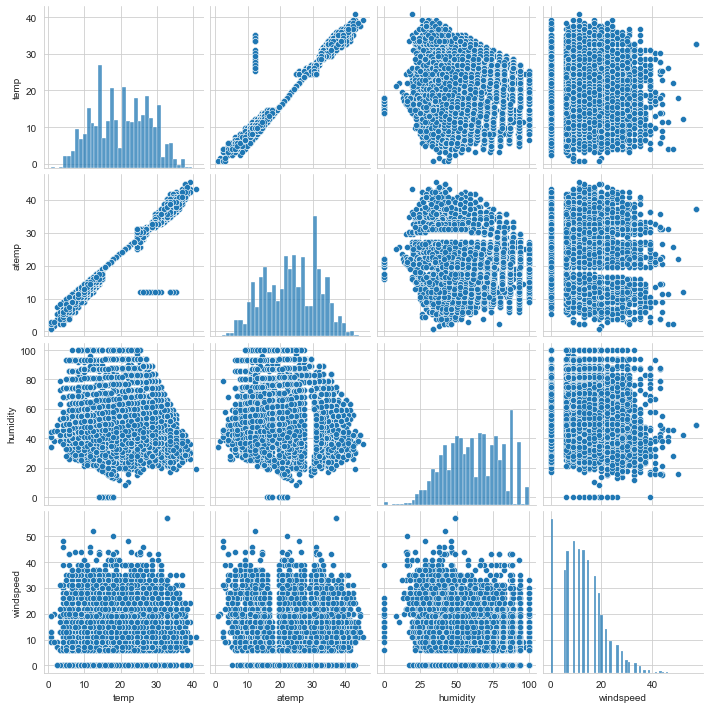

In [364]:
cols_num=['temp','atemp','humidity','windspeed']
plt.figure()
sns.pairplot(bike_train[cols_num])
plt.show()

### Feature Engineering

#### Categorical

+ holiday & working day are already assigned as '0' and '1'

In [365]:
cols_cat_f=['season','weather', 'month', 'hour', 'weekday']

In [366]:
from sklearn.preprocessing import OneHotEncoder

In [367]:
cols_cat_f

['season', 'weather', 'month', 'hour', 'weekday']

In [368]:
cols_cat_ohc_train=bike_train[cols_cat_f]
cols_cat_ohc_test=bike_test[cols_cat_f]

In [369]:
ohc = OneHotEncoder(sparse=False, handle_unknown='ignore')

In [370]:
ohc.fit(cols_cat_ohc_train)

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [371]:
t_cols_cat_train=ohc.transform(cols_cat_ohc_train)

In [372]:
t_cols_cat_test=ohc.transform(cols_cat_ohc_test)

In [373]:
cols_cat_ohc_train=pd.DataFrame(t_cols_cat_train, columns=ohc.get_feature_names())

In [374]:
cols_cat_ohc_test=pd.DataFrame(t_cols_cat_test, columns=ohc.get_feature_names())

In [375]:
cols_cat_ohc_train.astype('int').head()

,x0_1,x0_2,x0_3,x0_4,x1_1,x1_2,x1_3,x1_4,x2_1,x2_2,...,x3_21,x3_22,x3_23,x4_0,x4_1,x4_2,x4_3,x4_4,x4_5,x4_6
0,1,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,1,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,1,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,1,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [376]:
cols_cat_ohc_test.astype('int').head()

,x0_1,x0_2,x0_3,x0_4,x1_1,x1_2,x1_3,x1_4,x2_1,x2_2,...,x3_21,x3_22,x3_23,x4_0,x4_1,x4_2,x4_3,x4_4,x4_5,x4_6
0,1,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,1,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,1,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,1,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,1,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


#### Numerical

In [377]:
cols_num=['temp','atemp', 'humidity', 'windspeed']

In [378]:
cols_num_sca_train=bike_train[cols_num]

In [379]:
cols_num_sca_test=bike_test[cols_num]

In [380]:
from sklearn.preprocessing import MinMaxScaler

In [381]:
scaler=MinMaxScaler()

In [382]:
bike_train[cols_num]=scaler.fit_transform(bike_train[cols_num])

In [383]:
bike_test[cols_num]=scaler.fit_transform(bike_test[cols_num])

In [384]:
bike_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,weekday,hour
0,1,0,0,1,0.224490,0.305068,0.81,0.0,3,13,16,2011,1,1,5,0
1,1,0,0,1,0.204082,0.288064,0.80,0.0,8,32,40,2011,1,1,5,1
2,1,0,0,1,0.204082,0.288064,0.80,0.0,5,27,32,2011,1,1,5,2
3,1,0,0,1,0.224490,0.305068,0.75,0.0,3,10,13,2011,1,1,5,3
4,1,0,0,1,0.224490,0.305068,0.75,0.0,0,1,1,2011,1,1,5,4


In [385]:
bike_test.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,weekday,hour
0,1,0,1,1,0.25,0.2273,0.47619,0.464346,2011,1,20,3,0
1,1,0,1,1,0.25,0.2727,0.47619,0.000000,2011,1,20,3,1
2,1,0,1,1,0.25,0.2727,0.47619,0.000000,2011,1,20,3,2
3,1,0,1,1,0.25,0.2576,0.47619,0.196458,2011,1,20,3,3
4,1,0,1,1,0.25,0.2576,0.47619,0.196458,2011,1,20,3,4


### Transforming the train data

In [386]:
bike_train_concat=pd.concat([bike_train,cols_cat_ohc_train.astype(int)], axis=1 )

In [387]:
bike_train_concat.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,...,x3_21,x3_22,x3_23,x4_0,x4_1,x4_2,x4_3,x4_4,x4_5,x4_6
0,1,0,0,1,0.224490,0.305068,0.81,0.0,3,13,...,0,0,0,0,0,0,0,0,1,0
1,1,0,0,1,0.204082,0.288064,0.80,0.0,8,32,...,0,0,0,0,0,0,0,0,1,0
2,1,0,0,1,0.204082,0.288064,0.80,0.0,5,27,...,0,0,0,0,0,0,0,0,1,0
3,1,0,0,1,0.224490,0.305068,0.75,0.0,3,10,...,0,0,0,0,0,0,0,0,1,0
4,1,0,0,1,0.224490,0.305068,0.75,0.0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [388]:
bike_test_concat=pd.concat([bike_test,cols_cat_ohc_test.astype(int)], axis=1 )

In [389]:
bike_test_concat.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,...,x3_21,x3_22,x3_23,x4_0,x4_1,x4_2,x4_3,x4_4,x4_5,x4_6
0,1,0,1,1,0.25,0.2273,0.47619,0.464346,2011,1,...,0,0,0,0,0,0,1,0,0,0
1,1,0,1,1,0.25,0.2727,0.47619,0.000000,2011,1,...,0,0,0,0,0,0,1,0,0,0
2,1,0,1,1,0.25,0.2727,0.47619,0.000000,2011,1,...,0,0,0,0,0,0,1,0,0,0
3,1,0,1,1,0.25,0.2576,0.47619,0.196458,2011,1,...,0,0,0,0,0,0,1,0,0,0
4,1,0,1,1,0.25,0.2576,0.47619,0.196458,2011,1,...,0,0,0,0,0,0,1,0,0,0


###  Define X, y

In [390]:
bike_train_concat.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'casual', 'registered', 'count', 'year',
       'month', 'day', 'weekday', 'hour', 'x0_1', 'x0_2', 'x0_3', 'x0_4',
       'x1_1', 'x1_2', 'x1_3', 'x1_4', 'x2_1', 'x2_2', 'x2_3', 'x2_4', 'x2_5',
       'x2_6', 'x2_7', 'x2_8', 'x2_9', 'x2_10', 'x2_11', 'x2_12', 'x3_0',
       'x3_1', 'x3_2', 'x3_3', 'x3_4', 'x3_5', 'x3_6', 'x3_7', 'x3_8', 'x3_9',
       'x3_10', 'x3_11', 'x3_12', 'x3_13', 'x3_14', 'x3_15', 'x3_16', 'x3_17',
       'x3_18', 'x3_19', 'x3_20', 'x3_21', 'x3_22', 'x3_23', 'x4_0', 'x4_1',
       'x4_2', 'x4_3', 'x4_4', 'x4_5', 'x4_6'],
      dtype='object')

In [391]:
X=bike_train_concat.drop([ 'season', 'weather','atemp', 'casual', 'registered', 'count','year','month', 'day', 'weekday', 'hour'
       ], axis=1)

In [392]:
X

,holiday,workingday,temp,humidity,windspeed,x0_1,x0_2,x0_3,x0_4,x1_1,...,x3_21,x3_22,x3_23,x4_0,x4_1,x4_2,x4_3,x4_4,x4_5,x4_6
0,0,0,0.224490,0.81,0.000000,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0.204082,0.80,0.000000,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0.204082,0.80,0.000000,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0.224490,0.75,0.000000,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0.224490,0.75,0.000000,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,0,1,0.367347,0.50,0.456213,0,0,0,1,1,...,0,0,0,0,0,1,0,0,0,0
10882,0,1,0.346939,0.57,0.263195,0,0,0,1,1,...,0,0,0,0,0,1,0,0,0,0
10883,0,1,0.326531,0.61,0.263195,0,0,0,1,1,...,1,0,0,0,0,1,0,0,0,0
10884,0,1,0.326531,0.61,0.105325,0,0,0,1,1,...,0,1,0,0,0,1,0,0,0,0


In [393]:
y=bike_train_concat['count']

In [394]:
X.shape, y.shape

((10886, 56), (10886,))

In [395]:
bike_test_concat.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'year', 'month', 'day', 'weekday', 'hour',
       'x0_1', 'x0_2', 'x0_3', 'x0_4', 'x1_1', 'x1_2', 'x1_3', 'x1_4', 'x2_1',
       'x2_2', 'x2_3', 'x2_4', 'x2_5', 'x2_6', 'x2_7', 'x2_8', 'x2_9', 'x2_10',
       'x2_11', 'x2_12', 'x3_0', 'x3_1', 'x3_2', 'x3_3', 'x3_4', 'x3_5',
       'x3_6', 'x3_7', 'x3_8', 'x3_9', 'x3_10', 'x3_11', 'x3_12', 'x3_13',
       'x3_14', 'x3_15', 'x3_16', 'x3_17', 'x3_18', 'x3_19', 'x3_20', 'x3_21',
       'x3_22', 'x3_23', 'x4_0', 'x4_1', 'x4_2', 'x4_3', 'x4_4', 'x4_5',
       'x4_6'],
      dtype='object')

In [396]:
X_test=bike_test_concat.drop([ 'season', 'weather','atemp','year','month', 'day', 'weekday', 'hour'
       ], axis=1)

In [397]:
X_test.head()

,holiday,workingday,temp,humidity,windspeed,x0_1,x0_2,x0_3,x0_4,x1_1,...,x3_21,x3_22,x3_23,x4_0,x4_1,x4_2,x4_3,x4_4,x4_5,x4_6
0,0,1,0.25,0.47619,0.464346,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1,0,1,0.25,0.47619,0.000000,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,0,1,0.25,0.47619,0.000000,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,0,1,0.25,0.47619,0.196458,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,0,1,0.25,0.47619,0.196458,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0


In [398]:
X_test.shape

(6493, 56)

### Build the model

#### Linear Regression Model

In [517]:
from sklearn.linear_model import LinearRegression

In [518]:
lin_reg=LinearRegression()

In [519]:
lin_reg.fit(X,np.log1p(y))

LinearRegression()

In [520]:
print(f'The R^2 score of lin_reg is {round(lin_reg.score(X,np.log1p(y)),3)}')

The R^2 score of lin_reg is 0.804


In [521]:
y_pred_lin=np.expm1(lin_reg.predict(X))

In [522]:
y_pred_lin

array([ 20.84526897,  10.5116478 ,   6.20380512, ..., 139.78946592,
       117.55661676,  80.48269163])

In [523]:
y_pred_lin_test=np.expm1(lin_reg.predict(X_test))  #y predicts for test data

In [547]:
(y_pred_lin_test<0) = 0

SyntaxError: cannot assign to comparison (Temp/ipykernel_17760/234555916.py, line 1)

In [537]:
submission_df=pd.DataFrame(y_pred_lin_test.astype('int'), columns=['count'])

In [538]:
submission_df.head()

,count
0,20
1,12
2,7
3,3
4,2


In [539]:
sampleSubmission=pd.read_csv('../data/sampleSubmission.csv')

In [540]:
sampleSubmission['count']=submission_df['count']

In [541]:
sampleSubmission

,datetime,count
0,2011-01-20 00:00:00,20
1,2011-01-20 01:00:00,12
2,2011-01-20 02:00:00,7
3,2011-01-20 03:00:00,3
4,2011-01-20 04:00:00,2
...,...,...
6488,2012-12-31 19:00:00,-2147483648
6489,2012-12-31 20:00:00,-2147483648
6490,2012-12-31 21:00:00,-2147483648
6491,2012-12-31 22:00:00,-2147483648


In [542]:
sampleSubmission['count']

0               20
1               12
2                7
3                3
4                2
           ...    
6488   -2147483648
6489   -2147483648
6490   -2147483648
6491   -2147483648
6492   -2147483648
Name: count, Length: 6493, dtype: int32

In [543]:
sampleSubmission.to_csv('../data/sampleSubmission_kaggle.csv', index=0)

#### Random Forest Regression

In [248]:
from sklearn.ensemble import RandomForestRegressor

In [249]:
ran_for_reg=RandomForestRegressor()

In [250]:
ran_for_reg.fit(X,y)

RandomForestRegressor()

In [251]:
print(f'The R^2 score of ran_for_reg is {round(ran_for_reg.score(X,y),3)}')

The R^2 score of ran_for_reg is 0.978


In [252]:
y_pred_ran=ran_for_reg.predict(X)

#### Model evaluation metrics

##### Linear Regression

In [253]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [280]:
# The mean squared error 
print('Mean squared error: %.2f'
      % mean_squared_error(y, y_pred_lin))
# The root mean squared error
print('Root mean squared error: %.2f'
      % np.sqrt(mean_squared_error(y, y_pred_lin)))
# The mean absolute error 
print('Mean absolute error: %.2f'
      % mean_absolute_error(y, y_pred_lin))
# The coefficient of determination: 1 is perfect prediction f
print('Coefficient of determination: %.2f'
      % r2_score(y, y_pred_lin))

Mean squared error: 11893.88
Root mean squared error: 109.06
Mean absolute error: 79.00
Coefficient of determination: 0.64


##### Random Forest Regression

In [281]:
# The mean squared error 
print('Mean squared error: %.2f'
      % mean_squared_error(y, y_pred_ran))
# The root mean squared error
print('Root mean squared error: %.2f'
      % np.sqrt(mean_squared_error(y, y_pred_ran)))
# The mean absolute error 
print('Mean absolute error: %.2f'
      % mean_absolute_error(y, y_pred_ran))
# The coefficient of determination: 1 is perfect prediction f
print('Coefficient of determination: %.2f'
      % r2_score(y, y_pred_ran))

Mean squared error: 724.89
Root mean squared error: 26.92
Mean absolute error: 17.72
Coefficient of determination: 0.98


### Feature Expansion

In [1]:
from sklearn.preprocessing import PolynomialFeatures

In [257]:
# define a degree 2 for the polinomial
DEGREE = 2

# Instantiate the transformation 
poly = PolynomialFeatures(degree=DEGREE,include_bias=False)

In [258]:
# Fit & transform the X
X_poly=poly.fit_transform(X)

In [259]:
X_poly

array([[0.        , 0.        , 0.2244898 , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.20408163, ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.20408163, ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.        , 1.        , 0.32653061, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.32653061, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.30612245, ..., 0.        , 0.        ,
        0.        ]])

In [260]:
poly.get_feature_names()


['x0',
 'x1',
 'x2',
 'x3',
 'x4',
 'x5',
 'x6',
 'x7',
 'x8',
 'x9',
 'x10',
 'x11',
 'x12',
 'x13',
 'x14',
 'x15',
 'x16',
 'x17',
 'x18',
 'x19',
 'x20',
 'x21',
 'x22',
 'x23',
 'x24',
 'x25',
 'x26',
 'x27',
 'x28',
 'x29',
 'x30',
 'x31',
 'x32',
 'x33',
 'x34',
 'x35',
 'x36',
 'x37',
 'x38',
 'x39',
 'x40',
 'x41',
 'x42',
 'x43',
 'x44',
 'x45',
 'x46',
 'x47',
 'x48',
 'x49',
 'x50',
 'x51',
 'x52',
 'x53',
 'x54',
 'x55',
 'x0^2',
 'x0 x1',
 'x0 x2',
 'x0 x3',
 'x0 x4',
 'x0 x5',
 'x0 x6',
 'x0 x7',
 'x0 x8',
 'x0 x9',
 'x0 x10',
 'x0 x11',
 'x0 x12',
 'x0 x13',
 'x0 x14',
 'x0 x15',
 'x0 x16',
 'x0 x17',
 'x0 x18',
 'x0 x19',
 'x0 x20',
 'x0 x21',
 'x0 x22',
 'x0 x23',
 'x0 x24',
 'x0 x25',
 'x0 x26',
 'x0 x27',
 'x0 x28',
 'x0 x29',
 'x0 x30',
 'x0 x31',
 'x0 x32',
 'x0 x33',
 'x0 x34',
 'x0 x35',
 'x0 x36',
 'x0 x37',
 'x0 x38',
 'x0 x39',
 'x0 x40',
 'x0 x41',
 'x0 x42',
 'x0 x43',
 'x0 x44',
 'x0 x45',
 'x0 x46',
 'x0 x47',
 'x0 x48',
 'x0 x49',
 'x0 x50',
 'x0 x51',
 

In [261]:
# instantiate  Linear Regression
m_poly = LinearRegression()

# fit the model on X_train
m_poly.fit(X_poly, y)

# And the predictions
ypred = m_poly.predict(X_poly)


In [262]:
print(f'\n With DEGREE of {DEGREE}, I get {len(poly.get_feature_names())} features!')
print('\n',poly.get_feature_names())

print(f'\n with coefficients  {np.round(m_poly.coef_,2)}, {np.round(m_poly.intercept_,2)}')

print(f'\n The training R^2: {np.round(m_poly.score(X_poly, y),4)}')


 With DEGREE of 2, I get 1652 features!

 ['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49', 'x50', 'x51', 'x52', 'x53', 'x54', 'x55', 'x0^2', 'x0 x1', 'x0 x2', 'x0 x3', 'x0 x4', 'x0 x5', 'x0 x6', 'x0 x7', 'x0 x8', 'x0 x9', 'x0 x10', 'x0 x11', 'x0 x12', 'x0 x13', 'x0 x14', 'x0 x15', 'x0 x16', 'x0 x17', 'x0 x18', 'x0 x19', 'x0 x20', 'x0 x21', 'x0 x22', 'x0 x23', 'x0 x24', 'x0 x25', 'x0 x26', 'x0 x27', 'x0 x28', 'x0 x29', 'x0 x30', 'x0 x31', 'x0 x32', 'x0 x33', 'x0 x34', 'x0 x35', 'x0 x36', 'x0 x37', 'x0 x38', 'x0 x39', 'x0 x40', 'x0 x41', 'x0 x42', 'x0 x43', 'x0 x44', 'x0 x45', 'x0 x46', 'x0 x47', 'x0 x48', 'x0 x49', 'x0 x50', 'x0 x51', 'x0 x52', 'x0 x53', 'x0 x54', 'x0 x55', 'x1^2', 'x1 x2', 'x1 x3',

### Assumptions of Linear Regression

#### No multicollinearity

In [263]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [264]:
X

,holiday,workingday,temp,humidity,windspeed,x0_1,x0_2,x0_3,x0_4,x1_1,...,x3_21,x3_22,x3_23,x4_0,x4_1,x4_2,x4_3,x4_4,x4_5,x4_6
0,0,0,0.224490,0.81,0.000000,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0.204082,0.80,0.000000,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0.204082,0.80,0.000000,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0.224490,0.75,0.000000,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0.224490,0.75,0.000000,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,0,1,0.367347,0.50,0.456213,0,0,0,1,1,...,0,0,0,0,0,1,0,0,0,0
10882,0,1,0.346939,0.57,0.263195,0,0,0,1,1,...,0,0,0,0,0,1,0,0,0,0
10883,0,1,0.326531,0.61,0.263195,0,0,0,1,1,...,1,0,0,0,0,1,0,0,0,0
10884,0,1,0.326531,0.61,0.105325,0,0,0,1,1,...,0,1,0,0,0,1,0,0,0,0


In [265]:
vif=pd.DataFrame()
vif['variables'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]


In [266]:
vif.sort_values(by='VIF',ascending=False)

,variables,VIF
0,holiday,inf
1,workingday,inf
30,x3_5,inf
31,x3_6,inf
32,x3_7,inf
33,x3_8,inf
34,x3_9,inf
35,x3_10,inf
36,x3_11,inf
37,x3_12,inf


### Regularization

In [71]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

In [282]:
# Instantiate different models to compare
m_ridge = Ridge(alpha=.1, random_state=31)         # alpha 
m_lasso = Lasso(alpha=.1, random_state=31)
m_elastic_net = ElasticNet(alpha=.1, l1_ratio=.5,
                           random_state=31)

In [283]:
m_ridge.fit(X, y)       # Train the linear model with ridge regularization
m_lasso.fit(X, y)       # Train the linear model with lasso regularization
m_elastic_net.fit(X, y) # Train the linear model with elsticnet regularization

ElasticNet(alpha=0.1, random_state=31)

In [284]:
ypred_ridge = m_ridge.predict(X)
ypred_lasso = m_lasso.predict(X)
ypred_elastic = m_elastic_net.predict(X)

In [291]:
# r^2 and RMSE (root mean-squared error)

# The root mean squared error - Ridge
print('Ridge - Coefficient of determination: %.2f'
      % r2_score(y, ypred_ridge))
print('Ridge - Root mean squared error: %.2f'
      % np.sqrt(mean_squared_error(y, ypred_ridge)))

# The root mean squared error - Lasso
print('Lasso - Coefficient of determination: %.2f'
      % r2_score(y, ypred_lasso))
print('Lasso - Root mean squared error: %.2f'
      % np.sqrt(mean_squared_error(y, ypred_lasso)))

# The root mean squared error - ElasticNet
print('ElasticNet - Coefficient of determination: %.2f'
      % r2_score(y, ypred_elastic))
print('ElasticNet - Root mean squared error: %.2f'
      % np.sqrt(mean_squared_error(y, ypred_elastic)))


Ridge - Coefficient of determination: 0.64
Ridge - Root mean squared error: 109.02
Lasso - Coefficient of determination: 0.64
Lasso - Root mean squared error: 109.07
ElasticNet - Coefficient of determination: 0.49
ElasticNet - Root mean squared error: 129.67


### Hyperparameter Optimization

#### GridSearchCV

In [72]:
ran_for_reg.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [73]:
from sklearn.model_selection import GridSearchCV

##### Define the parameters for Grid Search

In [74]:
parameters = { 'n_estimators' : [2 ** i for i in range(3, 10)],  # parameters grid
              'max_depth': [2, 4, 8, 16, 32, None]
}

In [75]:
ran_for_reg_grid=RandomForestRegressor()

In [76]:
grid_cv_h = GridSearchCV(estimator=ran_for_reg_grid, param_grid=parameters, cv=5, scoring='r2')

In [77]:
grid_cv_h.fit(X,y)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [2, 4, 8, 16, 32, None],
                         'n_estimators': [8, 16, 32, 64, 128, 256, 512]},
             scoring='r2')

In [78]:
def print_results(results):
    print('BEST MODEL PARAMETERS: {}\n'.format(results.best_params_))
    means = results.cv_results_['mean_test_score']
    for mean, params in zip(means, results.cv_results_['params']):
        print('{}  for {}'.format(round(mean, 4), params))

In [79]:
print_results(grid_cv_h)

BEST MODEL PARAMETERS: {'max_depth': None, 'n_estimators': 64}

-0.2004  for {'max_depth': 2, 'n_estimators': 8}
-0.2368  for {'max_depth': 2, 'n_estimators': 16}
-0.2195  for {'max_depth': 2, 'n_estimators': 32}
-0.213  for {'max_depth': 2, 'n_estimators': 64}
-0.2118  for {'max_depth': 2, 'n_estimators': 128}
-0.2038  for {'max_depth': 2, 'n_estimators': 256}
-0.1993  for {'max_depth': 2, 'n_estimators': 512}
-0.0133  for {'max_depth': 4, 'n_estimators': 8}
0.0536  for {'max_depth': 4, 'n_estimators': 16}
0.0484  for {'max_depth': 4, 'n_estimators': 32}
0.0545  for {'max_depth': 4, 'n_estimators': 64}
0.0495  for {'max_depth': 4, 'n_estimators': 128}
0.0514  for {'max_depth': 4, 'n_estimators': 256}
0.047  for {'max_depth': 4, 'n_estimators': 512}
0.2789  for {'max_depth': 8, 'n_estimators': 8}
0.2864  for {'max_depth': 8, 'n_estimators': 16}
0.2955  for {'max_depth': 8, 'n_estimators': 32}
0.2899  for {'max_depth': 8, 'n_estimators': 64}
0.3019  for {'max_depth': 8, 'n_estimators': 

##### Collect the results

In [96]:
results_grid = pd.DataFrame(grid_cv_h.cv_results_)

In [97]:
results_grid[['mean_fit_time','rank_test_score',
            'param_max_depth', 'param_n_estimators','split0_test_score',
             'split1_test_score', 'split2_test_score', 
         'split3_test_score', 'split4_test_score','mean_test_score']].sort_values('mean_test_score', ascending=False).head()

,mean_fit_time,rank_test_score,param_max_depth,param_n_estimators,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score
38,2.968196,1,None,64,-0.312711,0.502094,0.419804,0.654325,0.681433,0.388989
41,23.925052,2,None,512,-0.303838,0.504059,0.405342,0.657302,0.681844,0.388942
34,23.429628,3,32,512,-0.317615,0.504609,0.417674,0.659033,0.680160,0.388772
27,18.709100,4,16,512,-0.267593,0.536765,0.414792,0.624528,0.631863,0.388071
40,12.048418,5,None,256,-0.307455,0.504333,0.409255,0.654539,0.679325,0.388000


##### Making predictions with the best model

In [98]:
ran_for_reg_best_grid = grid_cv_h.best_estimator_
ran_for_reg_best_grid

RandomForestRegressor(n_estimators=64)

In [99]:
y_pred_ran_for_reg_grid = ran_for_reg_best_grid.predict(X)

In [100]:
sum(y_pred_ran_for_reg_grid<0)

0

In [101]:
round(r2_score(y, y_pred_ran_for_reg_grid),3)

0.977

In [102]:
ran_for_reg_best_grid.score(X,y)

0.9769714509599571

In [103]:
mean_squared_error(y,y_pred_ran_for_reg_grid )

755.5735769201132

#### RandomizeSearchCV

In [104]:
from sklearn.model_selection import RandomizedSearchCV

In [105]:
ran_for_reg_random=RandomForestRegressor()

##### Define the parameters for Randomize Search

In [106]:
parameters = { 'n_estimators' : [2 ** i for i in range(3, 10)],  # parameters randomize
              'max_depth': [2, 4, 8, 16, 32, None]
}

In [107]:
random_cv_h = RandomizedSearchCV(estimator=ran_for_reg_random, param_distributions=parameters, n_iter=50, cv=5, scoring='r2')

In [108]:
random_cv_h.fit(X,y)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=50,
                   param_distributions={'max_depth': [2, 4, 8, 16, 32, None],
                                        'n_estimators': [8, 16, 32, 64, 128,
                                                         256, 512]},
                   scoring='r2')

In [94]:
print_results(random_cv_h)

BEST MODEL PARAMETERS: {'n_estimators': 128, 'max_depth': 32}

-0.204  for {'n_estimators': 8, 'max_depth': 2}
-0.2193  for {'n_estimators': 16, 'max_depth': 2}
-0.2078  for {'n_estimators': 32, 'max_depth': 2}
-0.205  for {'n_estimators': 64, 'max_depth': 2}
-0.2009  for {'n_estimators': 128, 'max_depth': 2}
-0.1994  for {'n_estimators': 256, 'max_depth': 2}
-0.2126  for {'n_estimators': 512, 'max_depth': 2}
0.0829  for {'n_estimators': 8, 'max_depth': 4}
0.0348  for {'n_estimators': 16, 'max_depth': 4}
0.038  for {'n_estimators': 32, 'max_depth': 4}
0.0486  for {'n_estimators': 64, 'max_depth': 4}
0.0483  for {'n_estimators': 128, 'max_depth': 4}
0.051  for {'n_estimators': 256, 'max_depth': 4}
0.0503  for {'n_estimators': 512, 'max_depth': 4}
0.2853  for {'n_estimators': 8, 'max_depth': 8}
0.2969  for {'n_estimators': 16, 'max_depth': 8}
0.2923  for {'n_estimators': 32, 'max_depth': 8}
0.2966  for {'n_estimators': 64, 'max_depth': 8}
0.2962  for {'n_estimators': 128, 'max_depth': 8}

##### Collect the results

In [562]:
results_random = pd.DataFrame(random_cv_h.cv_results_)

In [563]:
results_random[['mean_fit_time','rank_test_score',
            'param_max_depth', 'param_n_estimators','split0_test_score',
             'split1_test_score', 'split2_test_score', 
         'split3_test_score', 'split4_test_score','mean_test_score']].sort_values('mean_test_score', ascending=False).head()

,mean_fit_time,rank_test_score,param_max_depth,param_n_estimators,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score
34,24.191922,1,32,512,-0.312745,0.505695,0.420432,0.657530,0.680117,0.390206
32,5.752287,2,32,128,-0.301884,0.501918,0.409509,0.655922,0.680609,0.389215
41,24.238058,3,None,512,-0.309810,0.504856,0.409532,0.656266,0.681543,0.388477
27,15.489746,4,16,512,-0.272135,0.537009,0.417281,0.625918,0.632801,0.388175
40,11.261724,5,None,256,-0.316609,0.506196,0.414211,0.655868,0.681141,0.388161


##### Making predictions with the best model

In [565]:
ran_for_reg_best_random = random_cv_h.best_estimator_
ran_for_reg_best_random

RandomForestRegressor(max_depth=32, n_estimators=512)

In [566]:
y_pred_ran_for_reg_random = ran_for_reg_best_random.predict(X)

In [571]:
sum(y_pred_ran_for_reg_random<0)

0

In [567]:
round(r2_score(y, y_pred_ran_for_reg_random),3)

0.977

In [568]:
ran_for_reg_best_random.score(X,y)

0.9774620244185886

In [569]:
mean_squared_error(y,y_pred_ran_for_reg_random )

739.4777151167577

### Which is the best model?

In [577]:
lin_reg_model_r2=round(lin_reg.score(X,np.log1p(y)),3)
ran_reg_model_r2=round(ran_for_reg.score(X,y),3)
poly_r2=round(m_poly.score(X_poly,y),3)
ridge_r2=round(m_ridge.score(X,y),3)
lasso_r2=round(m_lasso.score(X,y),3)
elasticnet_r2=round(m_elastic_net.score(X,y),3)

lin_reg_mse=round(mean_squared_error(y, y_pred_lin),3)
ran_for_reg_mse=round(mean_squared_error(y, y_pred_ran),3)
poly_mse=round(mean_squared_error(y, ypred),3)
ridge_mse=round(mean_squared_error(y, ypred_ridge),3)
lasso_mse=round(mean_squared_error(y, ypred_lasso),3)
elasticnet_mse=round(mean_squared_error(y, ypred_elastic),3)

In [578]:
results = pd.DataFrame({
    'Model': [ 'Linear Regression', 
              'Random Forest Regression', 'Polynomial Features', 'Ridge', 'Lasso', 'ElasticNet'],
    'R2': [lin_reg_model_r2,ran_reg_model_r2, poly_r2,ridge_r2, lasso_r2,elasticnet_r2],

    'MSE':[lin_reg_mse,ran_for_reg_mse,poly_mse,ridge_mse,lasso_mse,elasticnet_mse]}
   
)
result_train = results.sort_values(by='R2', ascending=False)
result_train = result_train.set_index('Model')
result_train

,R2,MSE
Model,,
Random Forest Regression,0.978,724.888
Polynomial Features,0.862,4521.103
Linear Regression,0.804,12434.680
Ridge,0.638,11885.912
Lasso,0.637,11895.864
ElasticNet,0.488,16815.225
